In [1]:
###################EARTHFORMER
import os
import ctypes
import pandas as pd
libgcc_s = ctypes.CDLL('libgcc_s.so.1')
import warnings
from typing import Union, Dict
from shutil import copyfile
from copy import deepcopy
import inspect
import pickle
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.optim.lr_scheduler import LambdaLR, CosineAnnealingLR
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor, DeviceStatsMonitor, Callback
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from omegaconf import OmegaConf
import os
import argparse
from einops import rearrange
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.utilities.cloud_io import load as pl_load
from einops import rearrange
# We create a layer which take as input movies of shape
# (n_frames, width, height, channels) and returns a movie
# of identical shape.
import pylab as plt
def denseScatterHist1200(cp,tp,title):
    r2=np.corrcoef(cp,tp)[1,0]**2
    bias = np.mean(cp-tp)
    rmse = np.sqrt(np.mean((cp-tp)**2))
    nrmse=rmse/np.mean(tp)
    n=cp.shape[0]
    hist, xbins, ybins = np.histogram2d(tp,cp,(30, 30))
    extent = [xbins.min(),xbins.max(),ybins.min(),ybins.max()]

    plt.imshow(np.sqrt(np.ma.masked_where(hist == 0, hist).T),cmap='jet', origin='lower', extent=extent)
    ax.tick_params(labelsize=16)
    plt.xlabel('Measured DSR',fontsize=18)
    plt.ylabel('Estimated DSR',fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.yticks(np.arange(0,1200,100))
    plt.plot(np.arange(1250),'r')
    plt.axis([0,1210,0,1210])
    plt.text(100,870,'$R^2$={:.3f}\nBias={:.1f}\nRMSE={:.1f}\nrRMSE={:.1f}\nn={:}'.format(r2,bias,rmse,nrmse*100,n),fontsize=18)
    plt.title(title, size=20)
    #fig.savefig('/gpfs/data1/lianggp/lir/'+'instantaneous.png',bbox_inches = 'tight',dpi=600)
    return r2,bias,rmse,nrmse,n
def cal_latlon (hid, vid):
    lat_0 = 60
    lon_0 = -180
    res_x = 0.01                # 0.02 for the 2km grid
    res_y = 0.01                # 0.02 for the 2km grid
    tile_xdim = 600            # 300 for the 2km grid
    tile_ydim = 600            # 300 for the 2km grid
    
    y=0
    x=0

    # Output formula 
    lat_ulcnr = lat_0 - (vid*tile_ydim + y)*res_y        # upper-left corner latitude
    lon_ulcnr = lon_0 + (hid*tile_xdim + x)*res_y     # upper-left corner longitude
    return lat_ulcnr, lon_ulcnr

/home/lir/.conda/envs/torch/lib/python3.7/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /gpfs/data1/lianggp/lir/conda/envs/torch/lib/python3.7/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


In [2]:
def tileid(id):
    abilist=pd.read_csv('/gpfs/data1/lianggp/lir/2018/abi_list.csv')
    block_size=5
    df_list=abilist[abilist.id==id]
    iH=df_list.iH.unique()
    iV=df_list.iV.unique()
    fCol=int(df_list.fCol.unique()/block_size)
    fLine=int(df_list.fLine.unique()/block_size)
    
    if fCol<60 and fLine<60:
        tile_id=1
    if fCol<60 and fLine>=60:
        tile_id=2
        fLine=fLine-60
    if fCol>=60 and fLine<60:
        tile_id=3
        fCol=fCol-60
    if fCol>=60 and fLine>=60:
        tile_id=4
        fCol=fCol-60
        fLine=fLine-60
    return iH,iV,tile_id

In [3]:
input_fc=8
output_fc=12
orgi_fc=24
szamode='exrefdeduct'
idx='3'
tl='_tl'
tile_name='15v04h12v03h17v03h15v03h10v03h12v01h13v02'
time_res, ts='15min', 0.25
data_source='lstm'

time_range=np.arange(6, 21, ts)
if szamode=='exrefdeduct':
    szaval='exdsr_ref'
if szamode=='refdeduct':
    szaval='dsr_ref'

raw_folder = '/gpfs/data1/lianggp/lir/forcast/'
processed_folder = 'data/'
train_test_file = data_source+'_generated_'+szamode+'_'+tile_name+tl+'_'+str(orgi_fc)+'_all_train_test_data_earthformer.npz'
save_results=raw_folder+'process_results/ConvLSTM-PyTorch/test'+idx+'_'+train_test_file[:-4]+'/'
insitu_path = '/gpfs/data1/lianggp/lir/2018/surfrad/insitu/'
prediction_filepath = os.path.join(raw_folder, 'code/ConvLSTM-PyTorch/save_model','test'+idx,train_test_file[:-4]+'_'+str(input_fc)+'_'+str(output_fc)+'_prediction.npz')
if not os.path.exists(save_results):
    print('jj')
    os.makedirs(save_results, exist_ok=True)
print(save_results)
print(train_test_file)
print(time_range)

/gpfs/data1/lianggp/lir/forcast/process_results/ConvLSTM-PyTorch/test3_lstm_generated_exrefdeduct_15v04h12v03h17v03h15v03h10v03h12v01h13v02_tl_24_all_train_test_data_earthformer/
lstm_generated_exrefdeduct_15v04h12v03h17v03h15v03h10v03h12v01h13v02_tl_24_all_train_test_data_earthformer.npz
[ 6.    6.25  6.5   6.75  7.    7.25  7.5   7.75  8.    8.25  8.5   8.75
  9.    9.25  9.5   9.75 10.   10.25 10.5  10.75 11.   11.25 11.5  11.75
 12.   12.25 12.5  12.75 13.   13.25 13.5  13.75 14.   14.25 14.5  14.75
 15.   15.25 15.5  15.75 16.   16.25 16.5  16.75 17.   17.25 17.5  17.75
 18.   18.25 18.5  18.75 19.   19.25 19.5  19.75 20.   20.25 20.5  20.75]


In [4]:
tilelist=['h15v04','h12v03','h17v03','h15v03','h10v03','h12v01','h13v02']
idlist=[3,7,5,1,4,2,6]

## test original file

In [5]:
a=np.load(prediction_filepath ,allow_pickle=True)
y_pred=a['arr_0']
y_pred.shape

(19744, 12, 60, 60, 1)

In [6]:
X_test  = np.load(os.path.join(raw_folder, processed_folder,train_test_file),allow_pickle=True)['arr_1']
X_test.shape

(19744, 24, 60, 60, 1)

In [7]:
df_test = np.load(os.path.join(raw_folder, processed_folder,train_test_file),allow_pickle=True)['arr_3']
df_test = pd.DataFrame(df_test, columns = ['ids', 'iH', 'iV', 'Doy', 'time_id', 'tile_id', 'train'])
#df_test = df_test[(df_test.iH==iH)&(df_test.iV==iV)]
df_test

ids  iH iV  Doy time_id tile_id train
0          0  15  4    1       8       1     0
1          1  15  4    1       8       2     0
2          2  15  4    1       8       3     0
3          3  15  4    1       8       4     0
4         32  15  4    1      16       1     0
...      ...  .. ..  ...     ...     ...   ...
19739  21571  13  2  355      11       4     0
19740  21600  13  2  364      11       1     0
19741  21601  13  2  364      11       2     0
19742  21602  13  2  364      11       3     0
19743  21603  13  2  364      11       4     0

[19744 rows x 7 columns]

In [8]:
abilist=pd.read_csv('/gpfs/data1/lianggp/lir/2018/abi_list.csv')
abilist

id    name     lats      lons    network  use  swin  par  direct  \
0      1     bon  40.0500  -88.3700    SURFRAD  NaN     1    1       1   
1      2     fpk  48.3100 -105.1000    SURFRAD  NaN     1    1       1   
2      3     gwn  34.2500  -89.8700    SURFRAD  NaN     1    1       1   
3      4     dra  36.6200 -116.0200    SURFRAD  NaN     1    1       1   
4      5     psu  40.7200  -77.9300    SURFRAD  NaN     1    1       1   
..   ...     ...      ...       ...        ...  ...   ...  ...     ...   
129  256  US-xUK  39.0404  -95.1921  AMERIFLUX  NaN     1    1       0   
130  257  US-xUN  46.2339  -89.5373  AMERIFLUX  NaN     1    1       0   
131  258  US-xWD  47.1282  -99.2414  AMERIFLUX  NaN     1    1       0   
132  259  US-xWR  45.8205 -121.9519  AMERIFLUX  NaN     1    1       0   
133  260  US-xYE  44.9535 -110.5391  AMERIFLUX  NaN     1    1       0   

     diffuse  ...  miH  miV mLine  mCol     x    y       elev     vaz    vza  \
0          1  ...   11    4  2387   564  2175  770   213.0000  339.93  48.28   
1          1  ...   11    4   405    23  1731  523   623.3125  322.34  62.49   
2          1  ...   10    5  1379  1370  2062  997   101.0625  334.97  42.80   
3          1  ...    8    5   810  1651  1155  953   998.0625  304.57  60.14   
4          1  ...   12    4  2226   224  2594  740   375.5625  355.74  47.14   
..       ...  ...  ...  ...   ...   ...   ...  ...        ...     ...    ...   
129        1  ...   10    5   229  1454  1901  816   317.8125  329.91  49.76   
130        1  ...   11    4   903  1935  2193  562   517.5000  340.43  55.03   
131        1  ...   11    4   688   594  1884  548   574.5000  328.59  59.03   
132        1  ...    9    4  1002  1202  1240  643   393.5000  303.94  69.63   
133        1  ...   10    4  1210   425  1502  640  2132.2500  314.83  62.44   

                timezone  
0        America/Chicago  
1         America/Denver  
2        America/Chicago  
3    America/Los_Angeles  
4       America/New_York  
..                   ...  
129      America/Chicago  
130    America/Menominee  
131      America/Chicago  
132  America/Los_Angeles  
133       America/Denver  

[134 rows x 29 columns]

In [9]:
df_test=df_test.merge(abilist[['iH','iV','fCol','fLine','id']][:7],on=['iH','iV'])
block_size=5
df_test['fCol']=(df_test['fCol']/block_size).astype(int)
df_test['fLine']=(df_test['fLine']/block_size).astype(int)
df_test['fCol'] = np.where((df_test['fCol'] > 60),df_test['fCol']-60,df_test['fCol'])
df_test['fLine'] = np.where((df_test['fLine'] > 60),df_test['fLine']-60,df_test['fLine'])
df_test['utcdif']=df_test.apply(lambda x: round(cal_latlon(x.iH,x.iV)[1]/15), axis=1)
df_test

ids  iH iV  Doy time_id tile_id train  fCol  fLine  id  utcdif
0          0  15  4    1       8       1     0    35      2   3      -6
1          1  15  4    1       8       2     0    35      2   3      -6
2          2  15  4    1       8       3     0    35      2   3      -6
3          3  15  4    1       8       4     0    35      2   3      -6
4         32  15  4    1      16       1     0    35      2   3      -6
...      ...  .. ..  ...     ...     ...   ...   ...    ...  ..     ...
19739  21571  13  2  355      11       4     0    25     47   6      -7
19740  21600  13  2  364      11       1     0    25     47   6      -7
19741  21601  13  2  364      11       2     0    25     47   6      -7
19742  21602  13  2  364      11       3     0    25     47   6      -7
19743  21603  13  2  364      11       4     0    25     47   6      -7

[19744 rows x 11 columns]

In [10]:
df_sza=pd.DataFrame()
for tile in tilelist:
    df1=pd.read_pickle('/gpfs/data1/lianggp/lir/forcast/data/'+tile+'_sza_dsr_ref.pkl')
    df_sza=df_sza.append(df1)
df_sza

iH iV  doy time_id        sza     dsr_ref   exdsr_ref
0      15  4  001       8  78.164463  216.402142  278.940272
1      15  4  001       9  75.720429  267.748712  335.448744
2      15  4  001      10  73.367032  317.197361  389.286035
3      15  4  001      11  71.113606  364.551234  440.222123
4      15  4  001      12  68.970281  408.919709  488.038910
...    .. ..  ...     ...        ...         ...         ...
14122  13  2  365      30  72.747972  330.205834  403.342510
14123  13  2  365      31  74.019967  303.477530  374.411185
14124  13  2  365      32  75.423898  273.978964  342.265354
14125  13  2  365      33  76.951938  241.875179  307.044905
14126  13  2  365      34  78.596305  207.330298  268.899969

[100868 rows x 7 columns]

In [11]:
for i in range(output_fc+1):
    df_test['Hour_'+str(i)]=df_test['time_id'].apply(lambda x: int(time_range[x+input_fc-1+i]))
    df_test['minute']=df_test['time_id'].apply(lambda x: time_range[x+input_fc-1+i]%1*60)
    df_test['hour_'+str(i)]=np.nan
    df_test['doy_'+str(i)]=np.nan
    df_test['dsrref_'+str(i)]=np.nan
    df_test['insitu_'+str(i)]=np.nan
    df_test['cdsr_'+str(i)]=np.nan
df_test

ids  iH iV  Doy time_id tile_id train  fCol  fLine  id  ...  doy_11  \
0          0  15  4    1       8       1     0    35      2   3  ...     NaN   
1          1  15  4    1       8       2     0    35      2   3  ...     NaN   
2          2  15  4    1       8       3     0    35      2   3  ...     NaN   
3          3  15  4    1       8       4     0    35      2   3  ...     NaN   
4         32  15  4    1      16       1     0    35      2   3  ...     NaN   
...      ...  .. ..  ...     ...     ...   ...   ...    ...  ..  ...     ...   
19739  21571  13  2  355      11       4     0    25     47   6  ...     NaN   
19740  21600  13  2  364      11       1     0    25     47   6  ...     NaN   
19741  21601  13  2  364      11       2     0    25     47   6  ...     NaN   
19742  21602  13  2  364      11       3     0    25     47   6  ...     NaN   
19743  21603  13  2  364      11       4     0    25     47   6  ...     NaN   

       dsrref_11  insitu_11  cdsr_11  Hour_12  hour_12  doy_12  dsrref_12  \
0            NaN        NaN      NaN       12      NaN     NaN        NaN   
1            NaN        NaN      NaN       12      NaN     NaN        NaN   
2            NaN        NaN      NaN       12      NaN     NaN        NaN   
3            NaN        NaN      NaN       12      NaN     NaN        NaN   
4            NaN        NaN      NaN       14      NaN     NaN        NaN   
...          ...        ...      ...      ...      ...     ...        ...   
19739        NaN        NaN      NaN       13      NaN     NaN        NaN   
19740        NaN        NaN      NaN       13      NaN     NaN        NaN   
19741        NaN        NaN      NaN       13      NaN     NaN        NaN   
19742        NaN        NaN      NaN       13      NaN     NaN        NaN   
19743        NaN        NaN      NaN       13      NaN     NaN        NaN   

       insitu_12  cdsr_12  
0            NaN      NaN  
1            NaN      NaN  
2            NaN      NaN  
3            NaN      NaN  
4            NaN      NaN  
...          ...      ...  
19739        NaN      NaN  
19740        NaN      NaN  
19741        NaN      NaN  
19742        NaN      NaN  
19743        NaN      NaN  

[19744 rows x 90 columns]

In [12]:
for ind, rw in df_test.iterrows():
    try:
        i=0
        df_test.loc[ind,'hour_'+str(i)]=rw['Hour_'+str(i)]-rw['utcdif']
        df_test.loc[ind,'doy_'+str(i)]=rw['Doy']
        if rw['hour_'+str(i)]>=24:
            df_test.loc[ind,'hour_'+str(i)]=rw['hour_'+str(i)]-24
            df_test.loc[ind,'doy_'+str(i)]=rw['Doy']+1
        if rw['hour_'+str(i)]<0:
            df_test.loc[ind,'hour_'+str(i)]=rw['hour_'+str(i)]+24
            df_test.loc[ind,'doy_'+str(i)]=rw['Doy']-1
        dsr_ref=df_sza.loc[(df_sza['iH'] == rw.iH) & (df_sza['iV'] == rw.iV)& (df_sza['doy'] == '{0:03}'.format(rw.Doy))& (df_sza['time_id'] == (rw.time_id+input_fc-1+i))][szaval].values[0]
        df_test.loc[ind,'dsrref_'+str(i)]=dsr_ref
        df_test.loc[ind,'cdsr_'+str(i)]=X_test[ind, input_fc-1, rw.fCol, rw.fLine,0]
    except:
        continue

In [13]:
for ind, rw in df_test.iterrows():
    for i in range(1, output_fc+1):
        df_test.loc[ind,'hour_'+str(i)]=rw['Hour_'+str(i)]-rw['utcdif']
        df_test.loc[ind,'doy_'+str(i)]=rw['Doy']
        if rw['hour_'+str(i)]>=24:
            df_test.loc[ind,'hour_'+str(i)]=rw['hour_'+str(i)]-24
            df_test.loc[ind,'doy_'+str(i)]=rw['Doy']+1
        if rw['hour_'+str(i)]<0:
            df_test.loc[ind,'hour_'+str(i)]=rw['hour_'+str(i)]+24
            df_test.loc[ind,'doy_'+str(i)]=rw['Doy']-1
            
        try:
            dsr_ref=df_sza.loc[(df_sza['iH'] == rw.iH) & (df_sza['iV'] == rw.iV)& (df_sza['doy'] == '{0:03}'.format(rw.Doy))& (df_sza['time_id'] == (rw.time_id+input_fc-1+i))][szaval].values[0]
            df_test.loc[ind,'dsrref_'+str(i)]=dsr_ref
            df_test.loc[ind,'cdsr_'+str(i)]=y_pred[ind, i-1, rw.fCol, rw.fLine,0]
        except:
            print()

df_test

ids  iH iV  Doy time_id tile_id train  fCol  fLine  id  ...  doy_11  \
0          0  15  4    1       8       1     0    35      2   3  ...     1.0   
1          1  15  4    1       8       2     0    35      2   3  ...     1.0   
2          2  15  4    1       8       3     0    35      2   3  ...     1.0   
3          3  15  4    1       8       4     0    35      2   3  ...     1.0   
4         32  15  4    1      16       1     0    35      2   3  ...     1.0   
...      ...  .. ..  ...     ...     ...   ...   ...    ...  ..  ...     ...   
19739  21571  13  2  355      11       4     0    25     47   6  ...   355.0   
19740  21600  13  2  364      11       1     0    25     47   6  ...   364.0   
19741  21601  13  2  364      11       2     0    25     47   6  ...   364.0   
19742  21602  13  2  364      11       3     0    25     47   6  ...   364.0   
19743  21603  13  2  364      11       4     0    25     47   6  ...   364.0   

        dsrref_11  insitu_11   cdsr_11  Hour_12  hour_12  doy_12   dsrref_12  \
0      744.181568        NaN  0.704481       12     18.0     1.0  729.784026   
1      744.181568        NaN  0.651937       12     18.0     1.0  729.784026   
2      744.181568        NaN  0.613029       12     18.0     1.0  729.784026   
3      744.181568        NaN  0.627573       12     18.0     1.0  729.784026   
4      512.686876        NaN  0.722941       14     20.0     1.0  466.654886   
...           ...        ...       ...      ...      ...     ...         ...   
19739  412.817602        NaN  0.294120       13     20.0   355.0  386.190776   
19740  426.600675        NaN  0.241160       13     20.0   364.0  400.909988   
19741  426.600675        NaN  0.232779       13     20.0   364.0  400.909988   
19742  426.600675        NaN  0.349000       13     20.0   364.0  400.909988   
19743  426.600675        NaN  0.478306       13     20.0   364.0  400.909988   

       insitu_12   cdsr_12  
0            NaN  0.704589  
1            NaN  0.651835  
2            NaN  0.619044  
3            NaN  0.620429  
4            NaN  0.718582  
...          ...       ...  
19739        NaN  0.296478  
19740        NaN  0.233128  
19741        NaN  0.242979  
19742        NaN  0.351769  
19743        NaN  0.463929  

[19744 rows x 90 columns]

3
0


/home/lir/.conda/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()


1
2
3
4
5
6
7
8
9
10
11
12
7
0


/home/lir/.conda/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()


1
2
3
4
5
6
7
8
9
10
11
12
5
0


/home/lir/.conda/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()


1
2
3
4
5
6
7
8
9
10
11
12
1
0


/home/lir/.conda/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()


1
2
3
4
5
6
7
8
9
10
11
12
4
0


/home/lir/.conda/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()


1
2
3
4
5
6
7
8
9
10
11
12
2
0


/home/lir/.conda/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()


1
2
3
4
5
6
7
8
9
10
11
12
6
0


/home/lir/.conda/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()


1
2
3
4
5
6
7
8
9
10
11
12


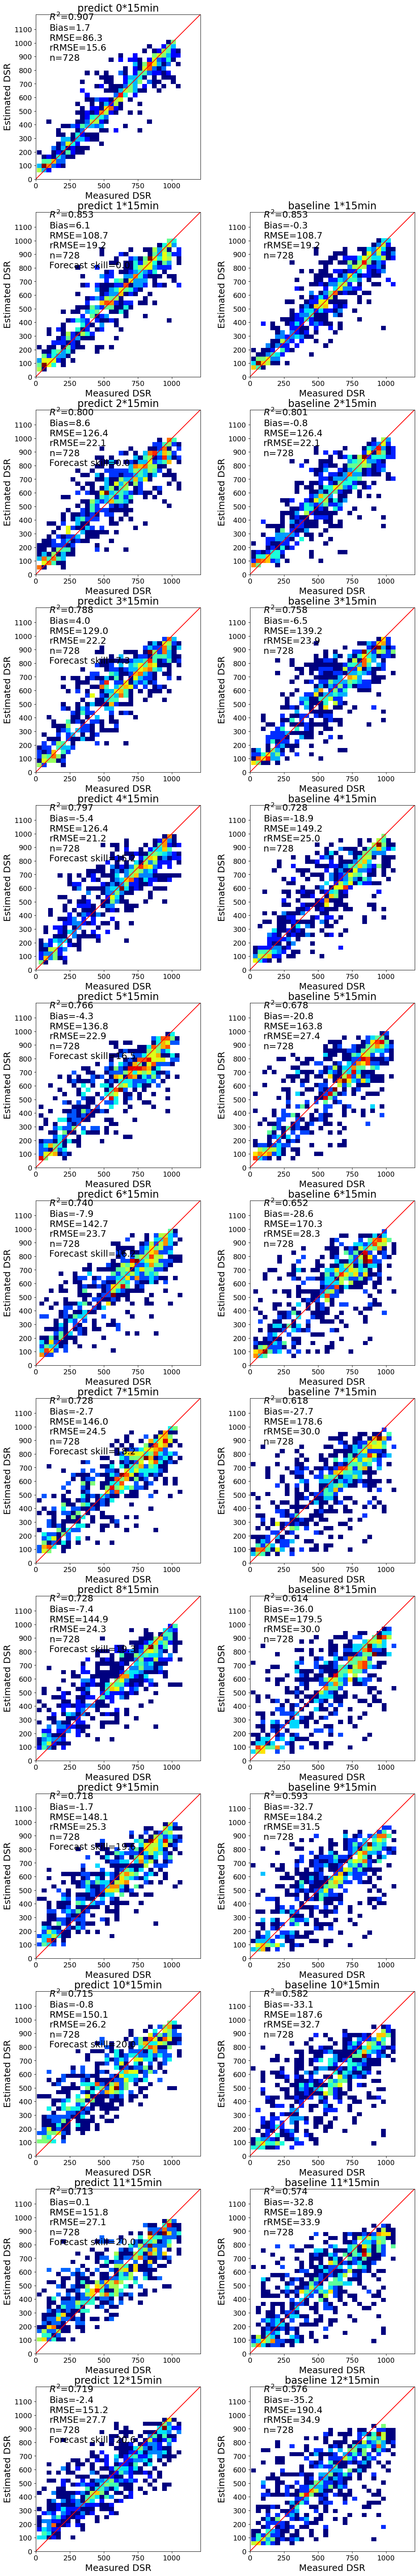

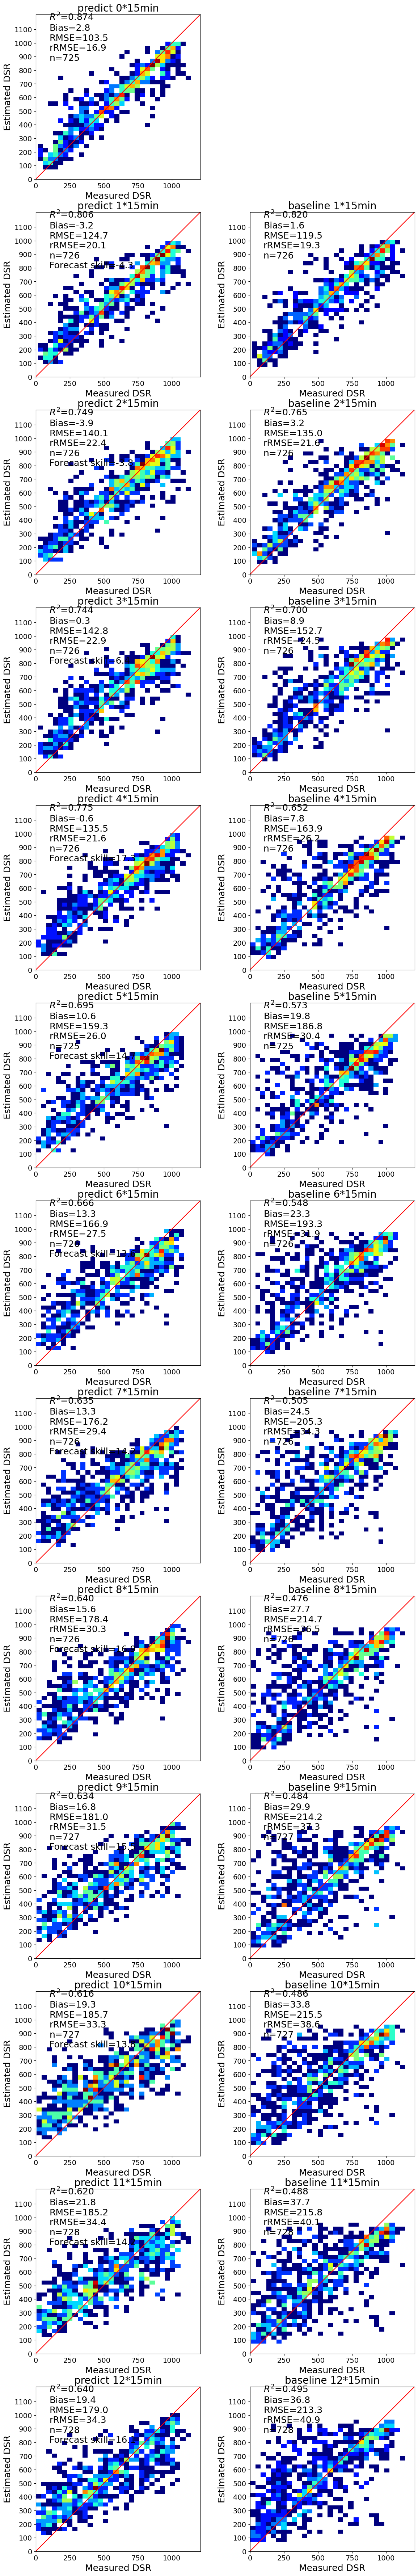

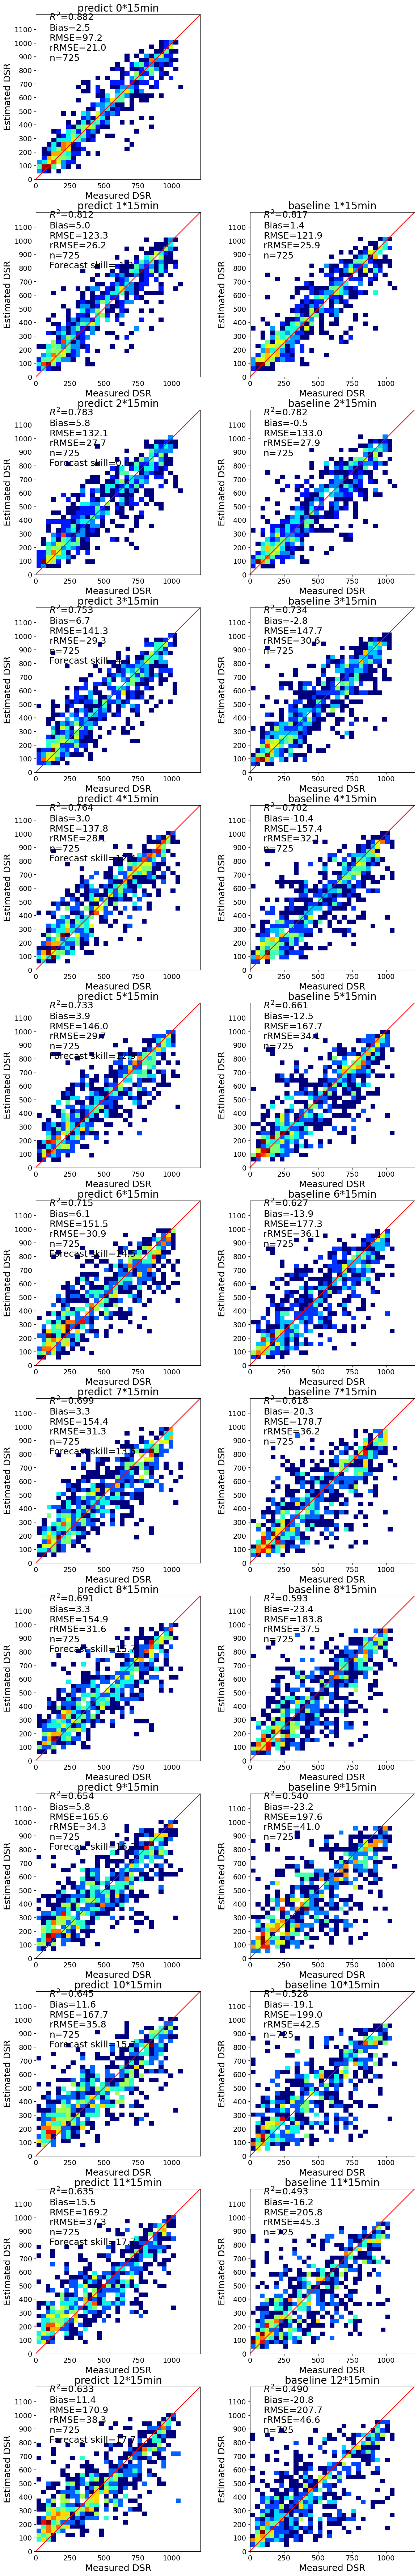

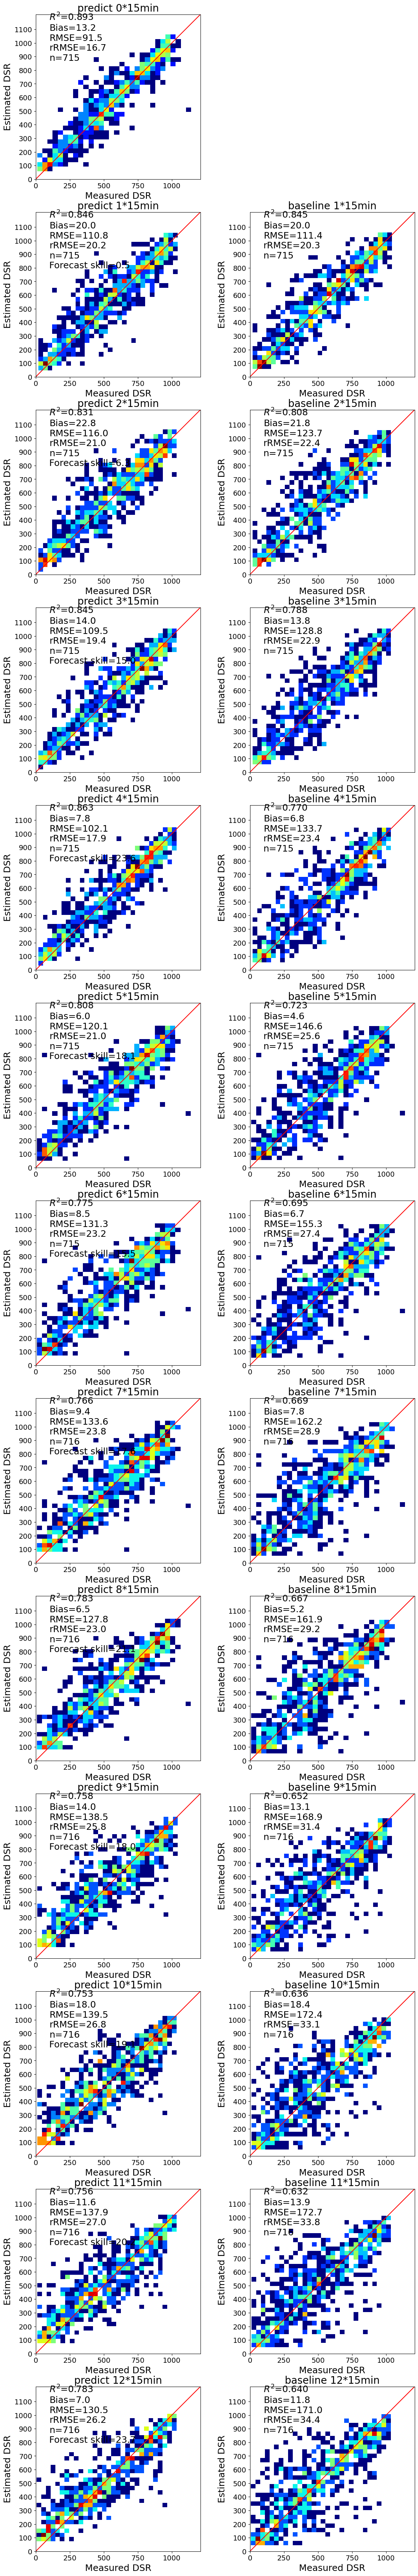

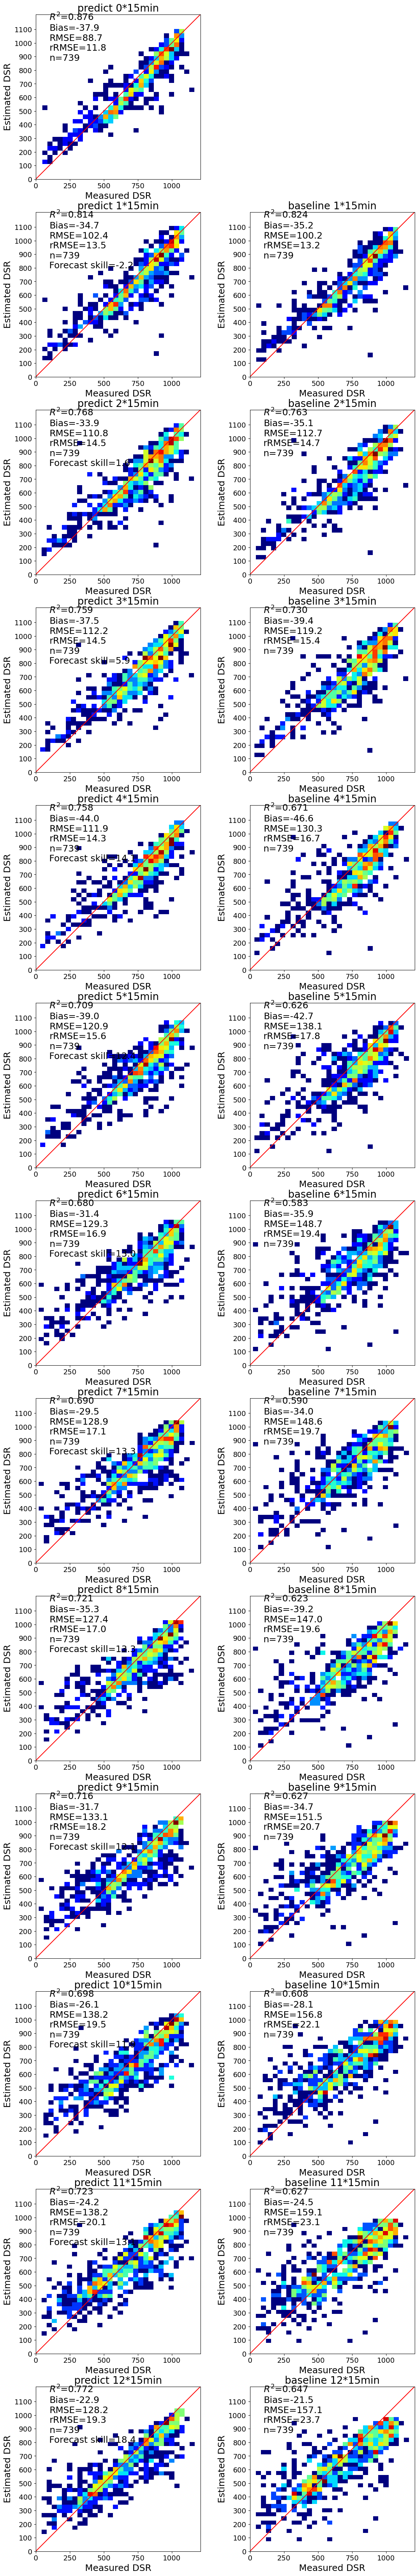

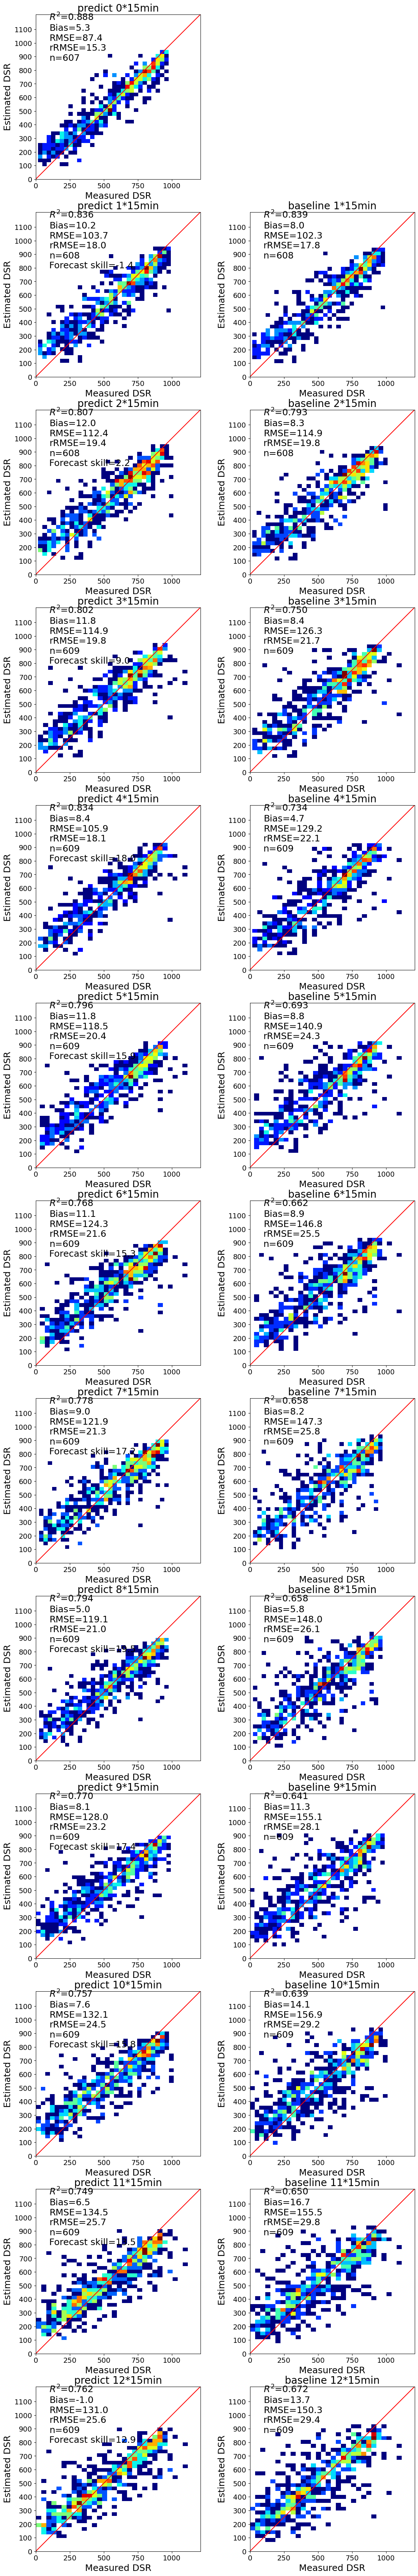

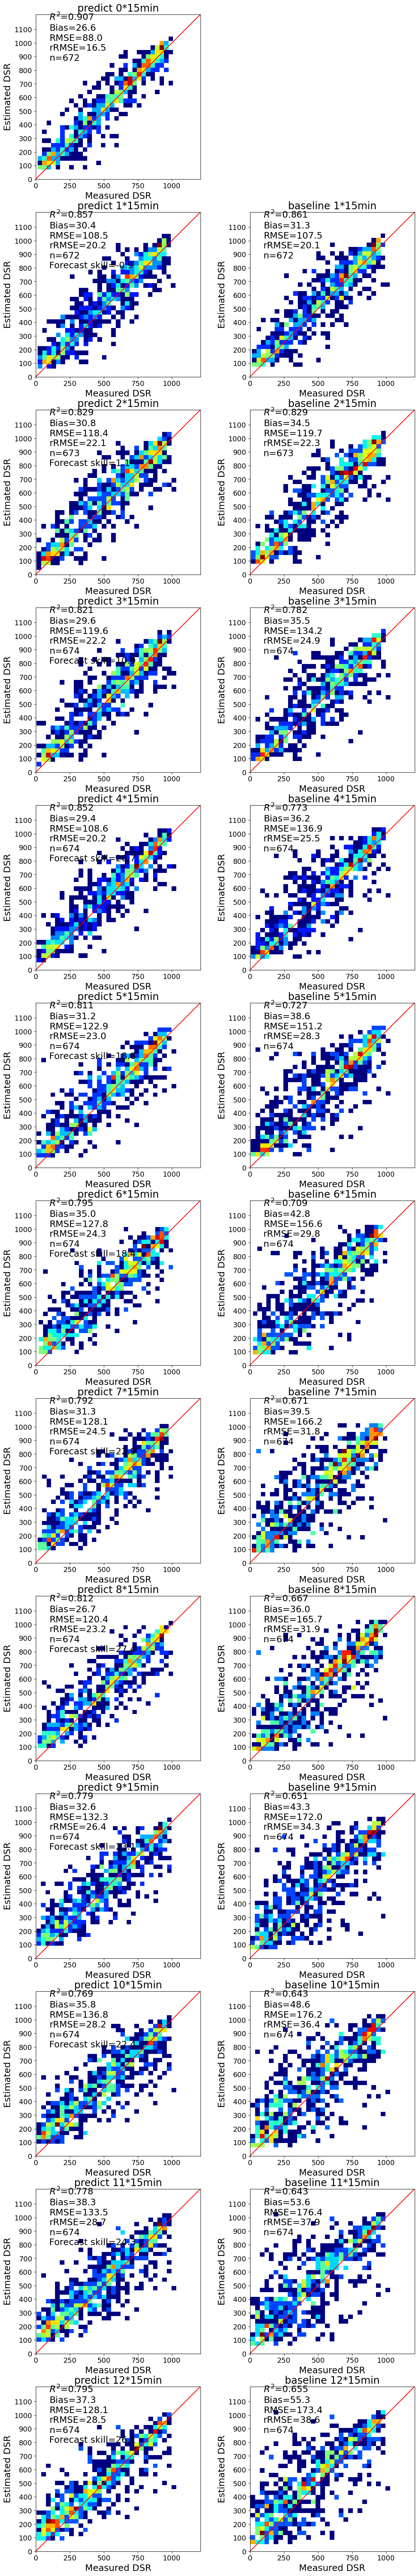

In [14]:
df_all=pd.DataFrame()
df_cvs=pd.DataFrame(columns=['ids','tf','R2', 'BIAS', 'RMSE','rRMSE','n','FS'])
for id in idlist:
    print(id)
    df_insitu=pd.read_pickle(insitu_path+str(int(id))+'.pkl')
    iH,iV,tile_id=tileid(id)
    swin_insitu=np.array(df_insitu.swin)
    for i in range(output_fc+1):
        print(i)
        df_test['times_'+str(i)]=df_test.apply(lambda x: x.minute+int(x['hour_'+str(i)])*60+(x['doy_'+str(i)]-1)*1440, axis=1)
        df_test['insitu_'+str(i)]=df_test['times_'+str(i)].apply(lambda x: np.nanmean(swin_insitu[int(x)-7:int(x)+7]))

    df_tk=df_test[(df_test.iH==iH[0])&(df_test.iV==iV[0])]
    df_tk=df_tk[(df_tk.tile_id==tile_id)]
    df_all=df_all.append(df_tk)
    fig=plt.figure(figsize=(14,7*(output_fc+1)))
    rmse_pred=[]
    rmse_base=[]
    for i in range(1, output_fc+1):
        ax = plt.subplot(output_fc+1,2,(2*i)+2)
        dftt=pd.DataFrame()
        dftt['predict']=df_tk['cdsr_0']*df_tk['dsrref_'+str(i)]
        dftt['true']=df_tk['insitu_'+str(i)]
        dftt=dftt.dropna()
        r2,bias,rmse,nrmse,n=denseScatterHist1200(dftt['predict'],dftt['true'],'baseline '+str(i)+'*'+time_res)
        rmse_base.append(rmse)
    for i in range(output_fc+1):
        ax = plt.subplot(output_fc+1,2,(2*i)+1)
        dftt=pd.DataFrame()
        dftt['predict']=df_tk['cdsr_'+str(i)]*df_tk['dsrref_'+str(i)]
        dftt['true']=df_tk['insitu_'+str(i)]
        dftt=dftt.dropna()
        r2,bias,rmse,nrmse,n=denseScatterHist1200(dftt['predict'],dftt['true'],'predict '+str(i)+'*'+time_res)
        fk=0
        if i > 0 :
            fk=(1-rmse/rmse_base[i-1])*100
            plt.text(100,800,'Forecast skill={:.1f}'.format(fk),fontsize=18)
        df2 = {'ids': id,'tf':i,'R2':r2, 'BIAS':bias, 'RMSE':rmse,'rRMSE':nrmse*100,'n':n,'FS':fk}
        df_cvs = df_cvs.append(df2, ignore_index = True)
    fig.savefig(save_results+train_test_file[:-4]+'_site'+str(id)+'_insitu_scatterplot.jpg',bbox_inches='tight',pad_inches = 0,dpi=400)
df_cvs.to_csv(save_results+tile_name+'_insitu.csv')
df_all.to_pickle(save_results+'tune_'+train_test_file[:-4]+'.pkl')

In [ ]:
#all
print(save_results)
df_all=pd.read_pickle(save_results+'tune_'+train_test_file[:-4]+'.pkl')
#df_all=df_all[(df_all.iH==15)&(df_all.iV==4)]
df_cvs=pd.DataFrame(columns=['ids','tf','R2', 'BIAS', 'RMSE','rRMSE','n','FS'])
fig=plt.figure(figsize=(14,7*(output_fc+1)))
rmse_pred=[]
rmse_base=[]
nrmse_base=[]
for i in range(1, output_fc+1):
    ax = plt.subplot(output_fc+1,2,(2*i)+2)
    dftt=pd.DataFrame()
    dftt['predict']=df_all['cdsr_0']*df_all['dsrref_'+str(i)]
    dftt['true']=df_all['insitu_'+str(i)]
    dftt=dftt.dropna()
    r2,bias,rmse,nrmse,n=denseScatterHist1200(dftt['predict'],dftt['true'],'baseline '+str(i)+'*'+time_res)
    rmse_base.append(rmse)
    nrmse_base.append(nrmse*100)
for i in range(output_fc+1):
    ax = plt.subplot(output_fc+1,2,(2*i)+1)
    dftt=pd.DataFrame()
    dftt['predict']=df_all['cdsr_'+str(i)]*df_all['dsrref_'+str(i)]
    dftt['true']=df_all['insitu_'+str(i)]
    dftt=dftt.dropna()
    r2,bias,rmse,nrmse,n=denseScatterHist1200(dftt['predict'],dftt['true'],'predict '+str(i)+'*'+time_res)
    fk=0
    if i > 0 :
        fk=(1-rmse/rmse_base[i-1])*100
        plt.text(100,800,'Forecast skill={:.1f}'.format(fk),fontsize=18)
    df2 = {'ids': 'all','tf':i,'R2':r2, 'BIAS':bias, 'RMSE':rmse,'rRMSE':nrmse*100,'rRMSE_Baseline':nrmse_base[i-1],'n':n,'FS':fk}
    df_cvs = df_cvs.append(df2, ignore_index = True)
fig.savefig(save_results+train_test_file[:-4]+'_surfrad'+'_insitu_scatterplot.jpg',bbox_inches='tight',pad_inches = 0,dpi=400)
df_cvs.to_csv(save_results+tile_name+'_surfrad_insitu.csv')    

/gpfs/data1/lianggp/lir/forcast/process_results/ConvLSTM-PyTorch/test3_lstm_generated_exrefdeduct_15v04h12v03h17v03h15v03h10v03h12v01h13v02_tl_24_all_train_test_data_earthformer/


In [ ]:
dfkt=pd.DataFrame()
for i in range(1, output_fc+1):
    dftt=pd.DataFrame()
    dftt['base']=df_all['cdsr_0']*df_all['dsrref_'+str(i)]
    dftt['predict']=df_all['cdsr_'+str(i)]*df_all['dsrref_'+str(i)]
    dftt['true']=df_all['insitu_'+str(i)]
    dftt=dftt.dropna()
    dfkt=dfkt.append(dftt)
    
r2,bias,rmse,nrmse,n=denseScatterHist1200(dfkt['predict'],dfkt['true'],'predict all')

## test other files

In [3]:
tile='h15v04'
tl='_tl'
iH=int(tile[1:3])
iV=int(tile[4:6])
lat_u,lon_u=cal_latlon(iH,iV)
utcdif=round(lon_u/15)

save_train_test_path='data/'+data_source+'_generated_'+szamode+'_'+tile+tl+'_'+str(orgi_fc)+'_'+time_res+'_train_test_data_earthformer.npz'
prediction_filepath = os.path.join(raw_folder, 'experiments/lstm/checkpoints/prediction',save_train_test_path[5:-4]+'_'+str(input_fc)+'_'+str(output_fc)+'_test_prediction.npz')

In [4]:
a=np.load(prediction_filepath,allow_pickle=True)
y=a['arr_0']
for i in range(len(y)):
    y[i]=y[i].numpy()
y_pred=np.concatenate( y, axis=0 )
y_pred.shape

(4663, 8, 60, 60, 1)

In [5]:
X_test  = np.load(save_train_test_path,allow_pickle=True)['arr_1']
X_test.shape

(4663, 24, 60, 60, 1)

In [6]:
df_test = np.load(save_train_test_path,allow_pickle=True)['arr_3']
df_test = pd.DataFrame(df_test, columns = ['ids', 'iH', 'iV', 'Doy', 'time_id', 'tile_id', 'train'])
df_test

ids  iH iV  Doy time_id tile_id train
0      4204  15  4   85      20       1     0
1      3106  15  4   70      17       3     0
2     18895  15  4  257      17       4     0
3     18156  15  4  248       4       1     0
4     18260  15  4  249      11       1     0
...     ...  .. ..  ...     ...     ...   ...
4658  12255  15  4  178      20       4     0
4659  23222  15  4  359      15       3     0
4660  18421  15  4  251      12       2     0
4661   6065  15  4  110      13       2     0
4662  15599  15  4  215       3       4     0

[4663 rows x 7 columns]

In [8]:
abilist=pd.read_csv('/gpfs/data1/lianggp/lir/2018/abi_list.csv')
print(abilist[(abilist.iH==iH)&(abilist.iV==iV)].id.drop_duplicates().values.tolist())
ll=abilist[(abilist.iH==iH)&(abilist.iV==iV)].id.drop_duplicates().values.tolist()

[3, 196, 229, 233, 237, 244, 253]


In [12]:
df=pd.DataFrame()
for ids in ll:
    print('ids',ids)
    block_size=5
    df_sza=pd.read_pickle('/gpfs/data1/lianggp/lir/forcast/data/'+tile+'_sza_dsr_ref.pkl')
    df_ids=pd.read_pickle(insitu_path+str(int(ids))+'.pkl')
    df_list=abilist[abilist.id==ids]
    fCol=int(df_list.fCol.unique()/block_size)
    fLine=int(df_list.fLine.unique()/block_size)
    
    #check tile_id
    if fCol<60 and fLine<60:
        tile_id=1
    if fCol<60 and fLine>=60:
        tile_id=2
        fLine=fLine-60
    if fCol>=60 and fLine<60:
        tile_id=3
        fCol=fCol-60
    if fCol>=60 and fLine>=60:
        tile_id=4
        fCol=fCol-60
        fLine=fLine-60
        
    insitu_path = '/gpfs/data1/lianggp/lir/2018/surfrad/insitu/'
    df_insitu=pd.read_pickle(insitu_path+str(int(ids))+'.pkl')
    swin_insitu=np.array(df_insitu.swin)
    
    for i in range(output_fc+1):
        df_test['Hour_'+str(i)]=df_test['time_id'].apply(lambda x: int(time_range[x+input_fc-1+i]))
        df_test['minute']=df_test['time_id'].apply(lambda x: time_range[x+input_fc-1+i]%1*60)
        df_test['hour_'+str(i)]=np.nan
        df_test['doy_'+str(i)]=np.nan
        df_test['dsrref_'+str(i)]=np.nan
        df_test['insitu_'+str(i)]=np.nan
        df_test['cdsr_'+str(i)]=np.nan
        
    for ind, rw in df_test.iterrows():
        try:
            i=0
            df_test.loc[ind,'hour_'+str(i)]=rw['Hour_'+str(i)]-utcdif
            df_test.loc[ind,'doy_'+str(i)]=rw['Doy']
            if df_test.loc[ind,'hour_'+str(i)]>=24:
                df_test.loc[ind,'hour_'+str(i)]=rw['hour_'+str(i)]-24
                df_test.loc[ind,'doy_'+str(i)]=rw['Doy_'+str(i)]+1
            if rw['hour_'+str(i)]<0:
                df_test.loc[ind,'hour_'+str(i)]=rw['hour_'+str(i)]+24
                df_test.loc[ind,'doy_'+str(i)]=rw['Doy_'+str(i)]-1
            dsr_ref=df_sza.loc[(df_sza['iH'] == iH) & (df_sza['iV'] == iV)& (df_sza['doy'] == '{0:03}'.format(rw.Doy))& (df_sza['time_id'] == (rw.time_id+input_fc-1+i))][szaval].values[0]
            df_test.loc[ind,'dsrref_'+str(i)]=dsr_ref
            df_test.loc[ind,'cdsr_'+str(i)]=X_test[ind, input_fc-1, fCol, fLine,0]

            for i in range(1, output_fc+1):
                df_test.loc[ind,'hour_'+str(i)]=rw['Hour_'+str(i)]-utcdif
                df_test.loc[ind,'doy_'+str(i)]=rw['Doy']
                if df_test.loc[ind,'hour_'+str(i)]>=24:
                    df_test.loc[ind,'hour_'+str(i)]=rw['hour_'+str(i)]-24
                    df_test.loc[ind,'doy_'+str(i)]=rw['Doy_'+str(i)]+1
                if rw['hour_'+str(i)]<0:
                    df_test.loc[ind,'hour_'+str(i)]=rw['hour_'+str(i)]+24
                    df_test.loc[ind,'doy_'+str(i)]=rw['Doy_'+str(i)]-1
                dsr_ref=df_sza.loc[(df_sza['iH'] == iH) & (df_sza['iV'] == iV)& (df_sza['doy'] == '{0:03}'.format(rw.Doy))& (df_sza['time_id'] == (rw.time_id+input_fc-1+i))][szaval].values[0]
                df_test.loc[ind,'dsrref_'+str(i)]=dsr_ref
                df_test.loc[ind,'cdsr_'+str(i)]=y_pred[ind, i-1, fCol, fLine,0]
                
        except:
            continue
            
    for i in range(output_fc+1):
        df_test['times_'+str(i)]=df_test.apply(lambda x: x.minute+int(x['hour_'+str(i)])*60+(x['doy_'+str(i)]-1)*1440, axis=1)
        df_test['insitu_'+str(i)]=df_test['times_'+str(i)].apply(lambda x: np.nanmean(swin_insitu[int(x)-7:int(x)+7]))
    
    df_tk=df_test[df_test.tile_id==tile_id]
    df=df.append(df_tk)

ids 3


/home/lir/.conda/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: Mean of empty slice


ids 196


/home/lir/.conda/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: Mean of empty slice


ids 229


/home/lir/.conda/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: Mean of empty slice


ids 233


/home/lir/.conda/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: Mean of empty slice


ids 237


/home/lir/.conda/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: Mean of empty slice


ids 244


/home/lir/.conda/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: Mean of empty slice


ids 253


/home/lir/.conda/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: Mean of empty slice


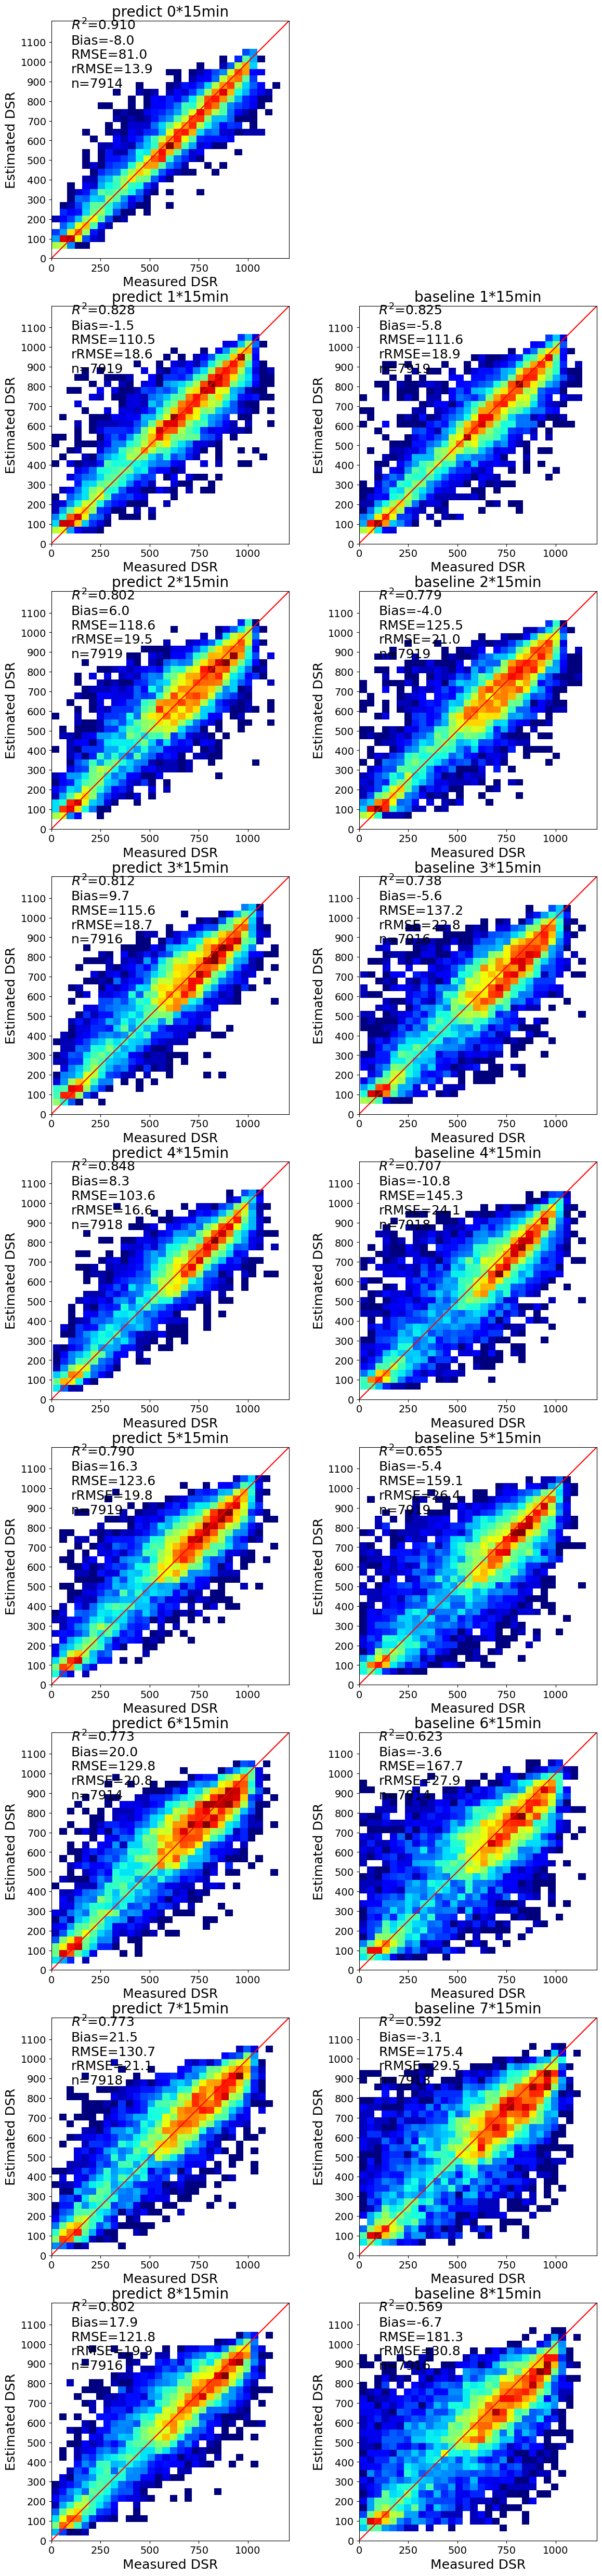

In [13]:
df_tk=df
fig=plt.figure(figsize=(14,7*(output_fc+1)))
for i in range(output_fc+1):
    ax = plt.subplot(output_fc+1,2,(2*i)+1)
    dftt=pd.DataFrame()
    dftt['predict']=df_tk['cdsr_'+str(i)]*df_tk['dsrref_'+str(i)]
    dftt['true']=df_tk['insitu_'+str(i)]
    dftt=dftt.dropna()
    denseScatterHist1200(dftt['predict'],dftt['true'],'predict '+str(i)+'*'+time_res)
for i in range(1, output_fc+1):
    ax = plt.subplot(output_fc+1,2,(2*i)+2)
    dftt=pd.DataFrame()
    dftt['predict']=df_tk['cdsr_0']*df_tk['dsrref_'+str(i)]
    dftt['true']=df_tk['insitu_'+str(i)]
    dftt=dftt.dropna()
    denseScatterHist1200(dftt['predict'],dftt['true'],'baseline '+str(i)+'*'+time_res)
fig.savefig(save_results+'earthformer_'+data_source+'_'+szamode+'_'+tile+tl+'_'+str(input_fc)+'_'+str(output_fc)+'_'+time_res+'_all_insitu_scatterplot.jpg',bbox_inches='tight',pad_inches = 0,dpi=400)